In [2]:
from utils.util import mkdir,seed_all
from omegaconf import OmegaConf
from cprint import *
from datasets.shape_net import ShapeNet
import torch
from models.Transform2D import Transform2D
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
from utils.visualizations import save_voxels
from PIL import Image
import os
import numpy as np
import datetime
%load_ext autoreload
%load_ext tensorboard
%autoreload 2

from evaluation.Evaluation import Evaluation


## Setup Expirement Folder

In [16]:
import time
seed_all(111)
today = time.strftime("%Y-%m-%d")
config = OmegaConf.load("./configs/global_configs.yaml")
cprint.ok(config)
description = "Checking Everything" # Describe Experiment params here
logs_dir = config["logs_dir"]
mkdir(logs_dir)
experiment_dir = f"{logs_dir}/{config['name']}"
mkdir(experiment_dir)
loss_log_title = "Loss Log " + today 

with open(f"{experiment_dir}/description.txt", "w") as file1:
    file1.write(description)
    
with open(f"{experiment_dir}/configs.txt", "w") as file1:
    file1.write(str(config))

with open(f"{experiment_dir}/loss_log.txt", "w") as file1:
    file1.write(loss_log_title)
    file1.write("\n")


mkdir(f"{experiment_dir}/checkpoints")
mkdir(f"{experiment_dir}/tb")
mkdir(f"{experiment_dir}/visuals")
mkdir(f"{experiment_dir}/evaluation")

{'logs_dir': 'logs/final_models/evaluations', 'is_train': True, 'name': 'evaluation_dev', 'device': 'cuda:0', 'batch_size': 8, 'n_epochs': 100, 'append_loss_every': 50, 'print_every': 150, 'validate_every': 4349, 'save_every': 500, 'save_every_nepochs': 10, 'start_epoch': 0, 'start_iteration': 0, 'visualize_every': 1000, 'model': {'lr': 0.0001, 'criterion': 'DICE_BCE', 'pos_weight': 1.8, 'fusion': 'AVG', 'encoder': {'patch_size': 16, 'sequence_length': 196, 'embedding_dim': 768, 'patch_padding': 3}, 'transformer_encoder': {'d_model': 768, 'nhead': 12, 'num_layers': 12}, 'transformer_decoder': {'d_model': 768, 'nhead': 12, 'num_layers': 8, 'num_pos_embeddings': 64}, 'fusion_decoder': {'d_model': 768, 'nhead': 6, 'num_layers': 2}}, 'evaluation': {'ckpt_path': 'logs/final_models/avg_fusion/checkpoints/epoch-latest.ckpt'}}
- logs/final_models/evaluations directory found
- logs/final_models/evaluations/evaluation_dev directory found
- logs/final_models/evaluations/evaluation_dev/checkpoints

- Creating new directory logs/final_models/evaluations/evaluation_dev/evaluation


## Load Dataset & Dataloaders
This uses a random split for train/validation/test - might need to look into paper if they have a pre-defined split

In [4]:
model = Transform2D()
# Declare device
device = torch.device('cpu')
if torch.cuda.is_available() and config['device'].startswith('cuda'):
    device = torch.device(config['device'])
    cprint.ok('Using device:', config['device'])
else:
    cprint.warn('Using CPU')

model.to(device)
model.load_ckpt(config['evaluation']['ckpt_path'])


Some weights of the model checkpoint at facebook/deit-base-distilled-patch16-224 were not used when initializing DeiTModel: ['distillation_classifier.bias', 'cls_classifier.bias', 'cls_classifier.weight', 'distillation_classifier.weight']
- This IS expected if you are initializing DeiTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeiTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['deit.pooler.dense.bias', 'deit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference

Using device: cuda:0
Model loaded from logs/final_models/avg_fusion/checkpoints/epoch-latest.ckpt


length:  43783


0it [00:00, ?it/s]

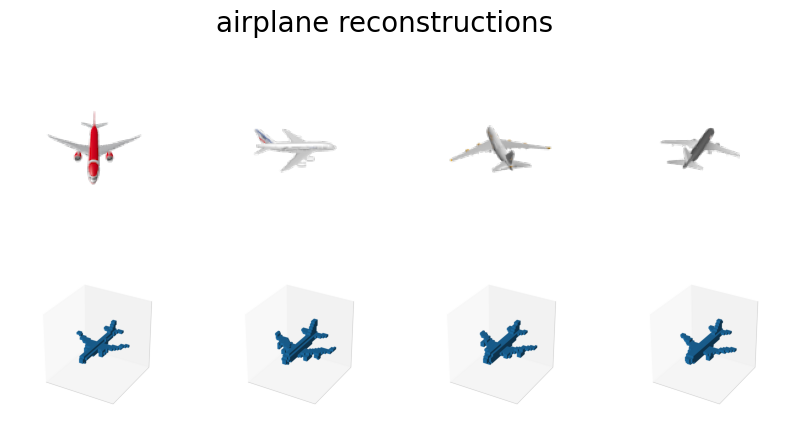

logs/final_models/evaluations/evaluation_dev/evaluation/airplane_evaluation saved


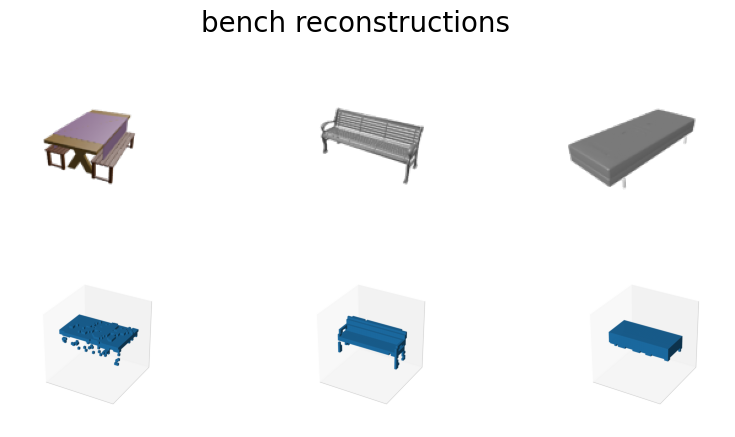

logs/final_models/evaluations/evaluation_dev/evaluation/bench_evaluation saved


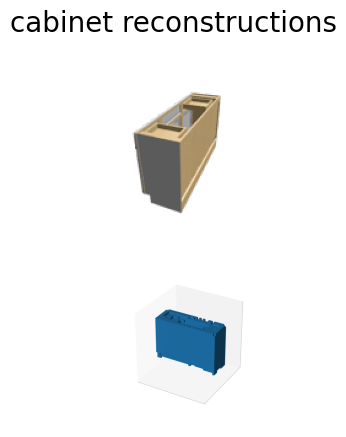

logs/final_models/evaluations/evaluation_dev/evaluation/cabinet_evaluation saved


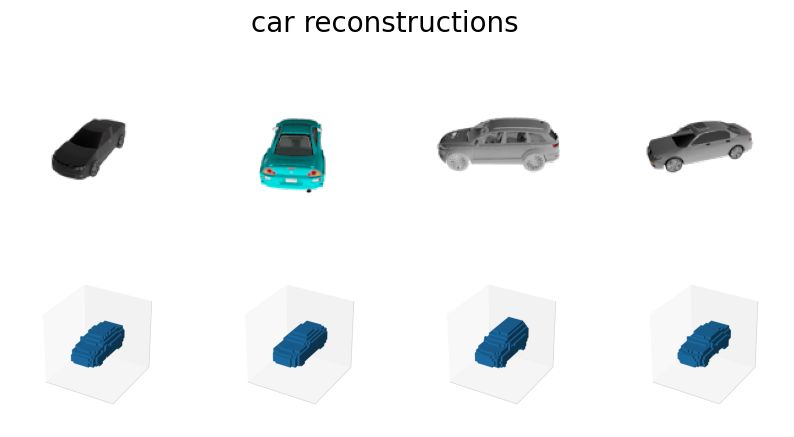

logs/final_models/evaluations/evaluation_dev/evaluation/car_evaluation saved


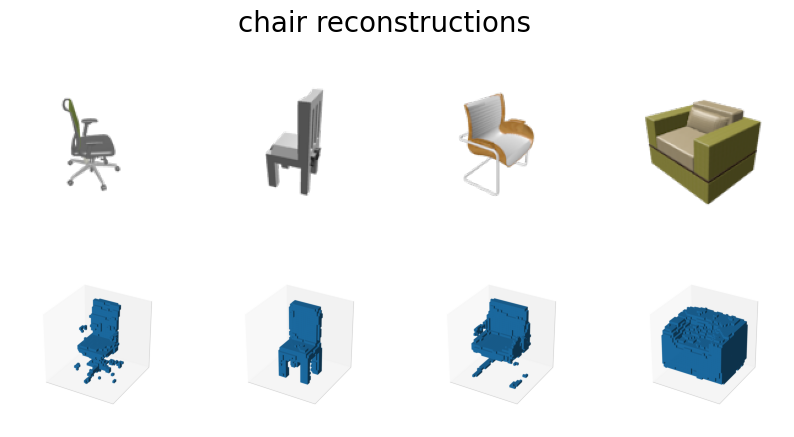

logs/final_models/evaluations/evaluation_dev/evaluation/chair_evaluation saved


<Figure size 1000x480 with 0 Axes>

logs/final_models/evaluations/evaluation_dev/evaluation/display_evaluation saved


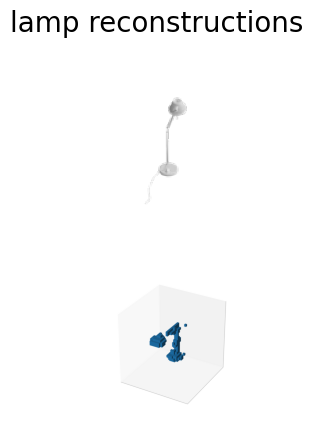

logs/final_models/evaluations/evaluation_dev/evaluation/lamp_evaluation saved


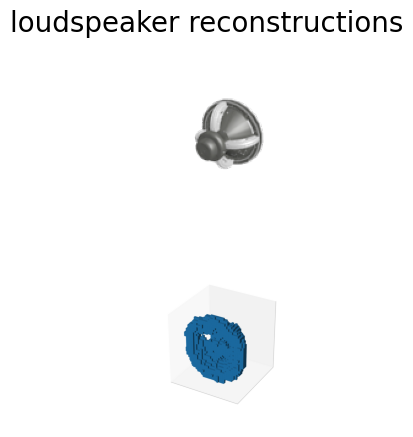

logs/final_models/evaluations/evaluation_dev/evaluation/loudspeaker_evaluation saved


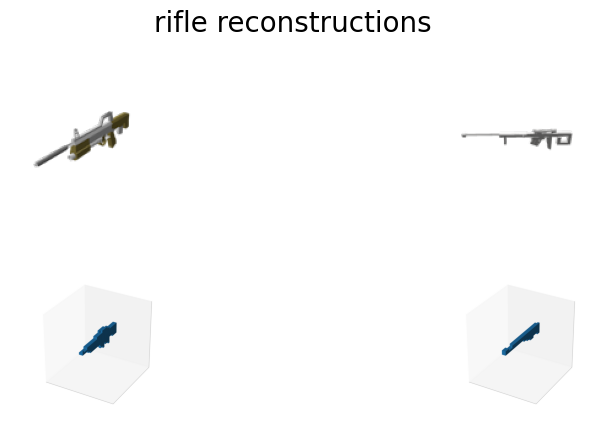

logs/final_models/evaluations/evaluation_dev/evaluation/rifle_evaluation saved


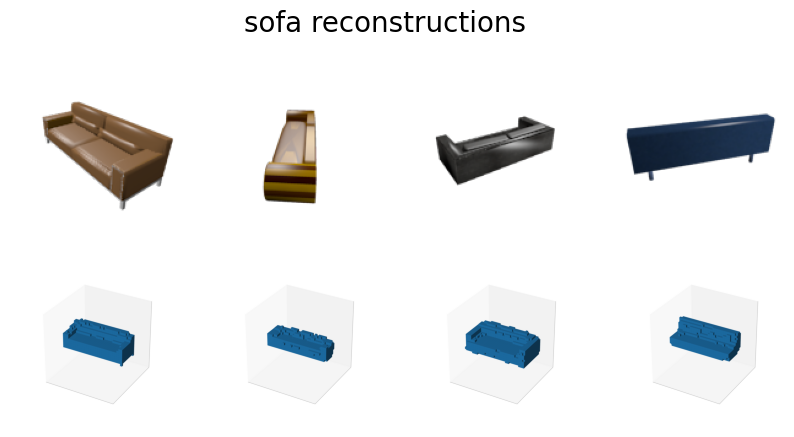

logs/final_models/evaluations/evaluation_dev/evaluation/sofa_evaluation saved


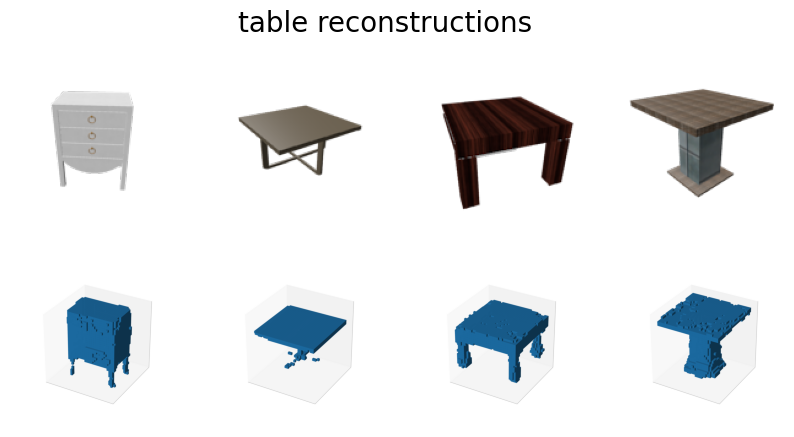

logs/final_models/evaluations/evaluation_dev/evaluation/table_evaluation saved


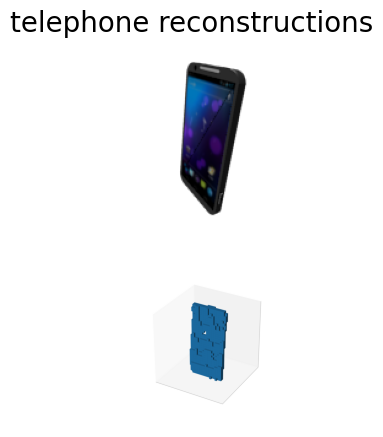

logs/final_models/evaluations/evaluation_dev/evaluation/telephone_evaluation saved


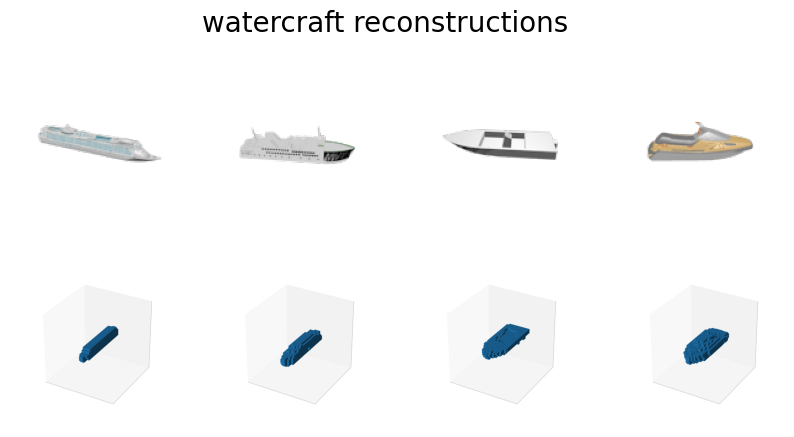

logs/final_models/evaluations/evaluation_dev/evaluation/watercraft_evaluation saved


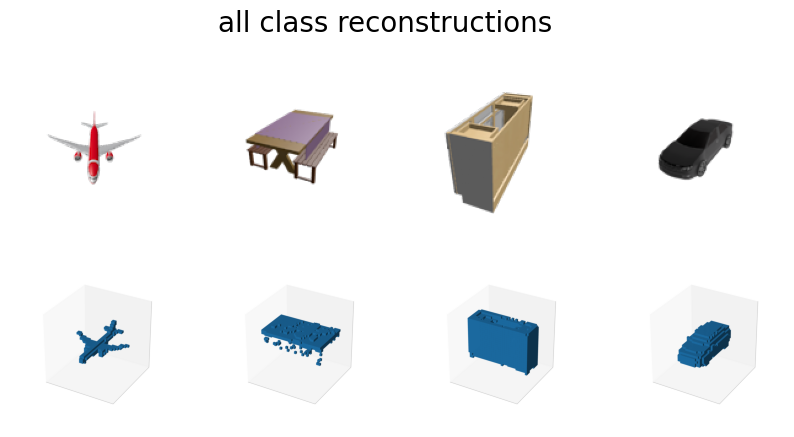

logs/final_models/evaluations/evaluation_dev/evaluation/all_1 saved


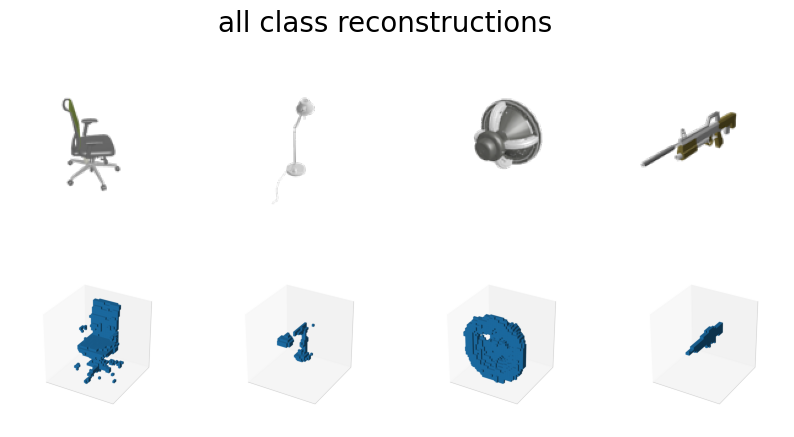

logs/final_models/evaluations/evaluation_dev/evaluation/all_2 saved


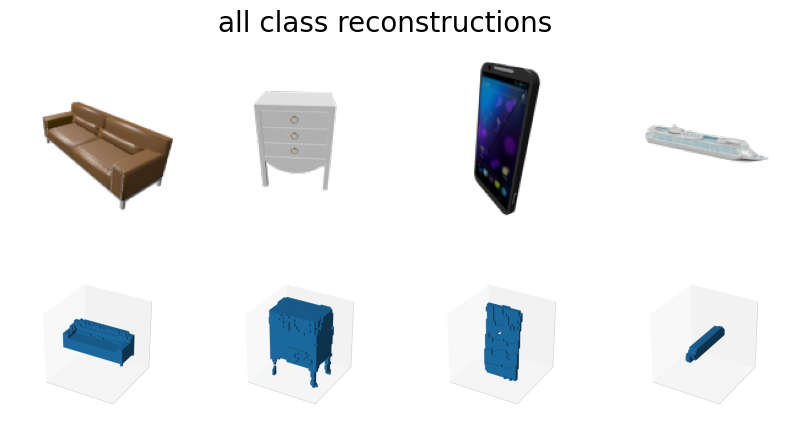

logs/final_models/evaluations/evaluation_dev/evaluation/all_3 saved


NameError: name 'reconstructions' is not defined

In [20]:
dataset = ShapeNet(cat="all",is_overfit=False, nimgs=16) #Change overfit param here & cat here
print('length: ', len(dataset))
dataset[0]
# train_ds, valid_ds, test_ds = torch.utils.data.random_split(
#     dataset, [35026, 4379, 4378])

train_ds, valid_ds, test_ds = torch.utils.data.random_split(
     dataset, [35026, 64, 8693])

train_dataloader = torch.utils.data.DataLoader(
        train_ds,   # Datasets return data one sample at a time; Dataloaders use them and aggregate samples into batches
        batch_size=config['batch_size'],   # The size of batches is defined here
        shuffle=True,    # Shuffling the order of samples is useful during training to prevent that the network learns to depend on the order of the input data
        num_workers=6,   # Data is usually loaded in parallel by num_workers
        pin_memory=True,  # This is an implementation detail to speed up data uploading to the GPU
        # worker_init_fn=train_dataset.worker_init_fn  TODO: Uncomment this line if you are using shapenet_zip on Google Colab
    )

validation_dataloader = torch.utils.data.DataLoader(
        valid_ds,   # Datasets return data one sample at a time; Dataloaders use them and aggregate samples into batches
        batch_size=config['batch_size'],   # The size of batches is defined here
        shuffle=True,    # Shuffling the order of samples is useful during training to prevent that the network learns to depend on the order of the input data
        num_workers=6,   # Data is usually loaded in parallel by num_workers
        pin_memory=True,  # This is an implementation detail to speed up data uploading to the GPU
        # worker_init_fn=train_dataset.worker_init_fn  TODO: Uncomment this line if you are using shapenet_zip on Google Colab
    )


evaluator = Evaluation(validation_dataloader, model, device, f"{experiment_dir}/evaluation")
evaluator.evaluate()
# evaluator.class_visualizations()
# evaluator.all_visualizations()
evaluator.save_dict()



## Loading Model

In [ ]:
torch.cuda.mem_get_info()

## Training

Checklist:
- Add tensorboard and make sure it logs to the `${experiment_dir}/tb` folder
- Visualize some reconstructions on validation set and make sure it logs to the `${expirement_dir}/visuals` folders

In [ ]:
from utils.visualizations import visualize_png
train_loss_running = 0.
best_loss_val = np.inf
model.train()

start_iteration = config["start_iteration"]
tb_dir = f"{experiment_dir}/tb"
writer = SummaryWriter(log_dir=tb_dir)
model_checkpoint_path = f"{experiment_dir}/checkpoints"
loss_log_name = f"{experiment_dir}/loss_log.txt"
visuals_path =  f"{experiment_dir}/visuals"
last_loss = 0.
last_iou = 0.


def train_one_epoch(epoch, writer):
     global best_loss_val
     global last_loss   
     global last_iou
     global start_iteration
     train_loss_running = 0.
     train_iou_running = 0.
     iteration_count = 0
     for batch_idx, batch in tqdm(enumerate(train_dataloader)):
         iteration = epoch * len(train_dataloader) + batch_idx   
         if(iteration<= start_iteration):
            continue
         ShapeNet.move_batch_to_device(batch, device)
         model.step(batch)
         metrics = model.get_metrics()
         loss = metrics["loss"]
         iou = metrics["iou"]
         train_loss_running += loss
         train_iou_running += iou
         iteration_count += 1
         if iteration % config["append_loss_every"] == (config["append_loss_every"] - 1) or (epoch==0 and iteration==0):
            message = '(epoch: %d, iters: %d, loss: %.6f, iou: %.6f)' % (epoch, iteration, loss.item(), iou.item())
            with open(loss_log_name, "a") as log_file:
                log_file.write('%s\n' % message)
            print(loss)
         
         if iteration % 1000 == 999:
            reconstructions = model.x
            target = batch["voxels"].squeeze(1)
            fig = save_voxels(reconstructions, target, visuals_path, iteration, is_train=True )
            writer.add_figure("Train/Reconstructions", fig, global_step=iteration, close=True, walltime=None)
                
         if iteration % config['print_every'] == (config['print_every'] - 1) or (epoch==0 and iteration==0):
            avg_train_loss = train_loss_running / iteration_count
            avg_iou = train_iou_running / iteration_count
            cprint.warn(f'[{epoch:03d}/{batch_idx:05d}] train_loss: {avg_train_loss:.6f}')
            writer.add_scalar("Train/Loss", avg_train_loss, iteration)
            writer.add_scalar("Train/iou", avg_iou, iteration)
            last_loss = avg_train_loss
            last_iou = avg_iou
            train_loss_running = 0.
            train_iou_running = 0.
            iteration_count = 0
         
         if iteration % config['save_every'] == (config['save_every'] - 1):
            model.save(model_checkpoint_path, "latest")
            
        
         if iteration % config['validate_every'] == (config['validate_every'] - 1) or (epoch==0 and iteration==0):
            cprint.ok("Running Validation")
            model.eval()
            loss_val = 0.
            iou_val = 0.
            index_batch = 0
            
            for batch_idx, batch_val in tqdm(enumerate(validation_dataloader)):
                ShapeNet.move_batch_to_device(batch_val, device)
                with torch.no_grad():
                    model.inference(batch_val)
                    metrics = model.get_metrics()
                    loss_val +=  metrics["loss"]
                    iou_val += metrics["iou"]
                    index_batch += 1
            avg_loss_val = loss_val / (index_batch)
            avg_iou_val = iou_val / (index_batch)
            reconstructions = model.x
            target = batch_val["voxels"].squeeze(1)
            fig = save_voxels(reconstructions, target, visuals_path, iteration, is_train=False )
            writer.add_figure("Validation/Reconstructions", fig, global_step=iteration, close=True, walltime=None)
            
            if avg_loss_val < best_loss_val:
                model.save(model_checkpoint_path, "best")
                best_loss_val = avg_loss_val
            
            cprint.warn(f'[{epoch:03d}/{batch_idx:05d}] val_loss: {avg_loss_val:.6f} | best_loss_val: {best_loss_val:.6f}')
            writer.add_scalar("Validation/Loss", avg_loss_val, iteration)
            #import pdb;pdb.set_trace();
            writer.add_scalars('Validation/LossComparison',
                   { 'Training' : last_loss, 'Validation' : avg_loss_val },
                    iteration)
            
            writer.add_scalars("Validation/iouComparison",
                                 { 'Training' : last_iou, 'Validation' : avg_iou_val},
                                     iteration)
            
            writer.flush()
      
     return last_loss

     



start_epoch = config["start_epoch"]
for epoch in tqdm(range(config['n_epochs'])):
    if epoch < start_epoch:
        continue
    avg_loss = train_one_epoch(epoch, writer) 
    #if(epoch % config["save_every_nepochs"]==0):
    model.save(model_checkpoint_path, epoch)
    model.update_lr()
    writer.close()
            